In [1]:
import numpy as np
import pandas as pd
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
# data_path = 'raw/expr_matrix_10day_log_normalized.txt'   # 11566 cells and 2000 genes
data_path = 'raw/SCTransform_10day_pesudocell_matrix.txt'
# data_path = 'raw/SCTransformed_10day_3000var.genes_pesudocell.txt'
output_folder = 'out'
tissue_path = 'raw/myshape.npy'
hvg_path = 'raw/high_variable_genes_10day.txt'
location_marker = 'raw/dge_full.txt'
atlas_path = 'raw/atlas.txt'

In [3]:
nn = 5
alpha_linear = 0
cell_nb = 3000
### select 3 markers that have no overlap
# insitu_genes = ['SMED30004921','SMED30017714','SMED30026600']
insitu_genes = np.genfromtxt(atlas_path, usecols=range(29), dtype='str', max_rows=1)

### load dataset

In [4]:
# load dataset:  expression matrix   col-gene,row-cell
dataset = novosparc.io.load_data(data_path)

In [5]:
dataset.shape

(1005, 1000)

In [6]:
# just to view gene names and the matrix
gene_names = np.asarray(dataset.var.index.tolist())

In [7]:
# ### set average gene expr close to 1
# ### not sure about its impact, but perhaps it could get things closer to marker's binary value????

# my = dataset.X
# for i in range(my.shape[0]):
#     divide_by = np.average(my[i][my[i]>0])
#     my[i] = my[i]/divide_by+0.00000001   
# dataset.X = my

In [8]:
# save the set to dataset.raw
dataset.raw = dataset
# select only genes in hvg_list
dataset, hvg = novosparc.pp.subset_to_hvg(dataset, hvg_file = hvg_path) # dataset[:,dataset.var.index.isin(gene_list)], gene_list

In [9]:
# # downsample data --- current hvg list is not correct
# cells_selected, dataset = novosparc.pp.subsample_dataset(dataset, min_num_cells=3000, max_num_cells=3100)

In [10]:
dataset.shape

(1005, 985)

In [11]:
print(np.max(dataset.X),np.min(dataset.X),np.average(dataset.X))

66.53928 0.0 0.76950324


### load target space (location)

In [12]:
# load target space
# locations = novosparc.geometry.create_target_space_from_image(tissue_path) #

locations = np.load(tissue_path)
locations.shape

(66203, 2)

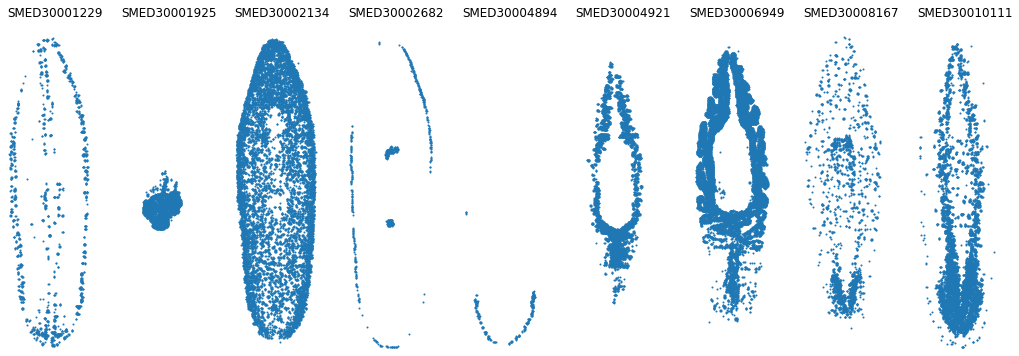

In [13]:
# just to check if atlas is correct
plt.figure(figsize=(9*2,6))
for i in range(min(len(insitu_genes),9)):
    myimg = np.load('chk/{}.npy'.format(insitu_genes[i].split('.')[0]))
    myloc = locations[myimg==1]
    plt.subplot(1,9,i+1)
    plt.scatter(myloc[:, 0], myloc[:, 1],s=1)
    plt.title(insitu_genes[i])
    plt.xlim(0,200)
    plt.ylim(0,500)
    plt.axis('off')
plt.show()    

In [14]:
# subsample the locations to save effort -- low resolution now
cell_nb = cell_nb #dataset.shape[0] * 5
seed = np.random.choice(locations.shape[0], cell_nb,replace=False)  ### -------- later to select markers   3000  11566  cell_nb
locations = locations[seed, :]
locations.shape

(3000, 2)

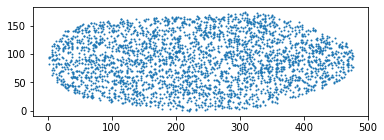

In [15]:
plt.figure(figsize=(6,2))
plt.scatter(locations[:, 1], locations[:, 0],s=1)
plt.show()

### Reconstruction
https://github.com/rajewsky-lab/novosparc/blob/master/reconstruct_drosophila_embryo_tutorial.ipynb

In [16]:
#Reconstruct the tissue de novo/with marker
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations, output_folder=output_folder)
locations.shape

(3000, 2)

In [17]:
# find indices of marker genes in dge dataset
gene_names = tissue.gene_names     
markers_in_sc = np.array([], dtype='int')
markers_in_sc_name = []
for marker in insitu_genes:   
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
        markers_in_sc_name.append(marker)

In [18]:
# load atlas matrix
# make sure atlas_matrix.shape[1]==tissue.dge[:, markers_in_sc].shape[1] (or dataset.dge)
# also don't forget to extract points that used in locations only  (seed)
atlas_matrix = pd.read_csv(atlas_path,sep='\t')
atlas_matrix = atlas_matrix[markers_in_sc_name]
atlas_matrix = atlas_matrix.to_numpy()
atlas_matrix = atlas_matrix[seed,:]
atlas_matrix.shape

(3000, 14)

In [19]:
np.unique(atlas_matrix)

array([0, 1], dtype=int64)

In [20]:
tissue.setup_reconstruction(markers_to_use=markers_in_sc, insitu_matrix=atlas_matrix, num_neighbors_s=nn, num_neighbors_t=nn)

Setting up for reconstruction ... done ( 4.15 seconds )


##### set alpha_linear

In [21]:
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=5e-3) ########调试alpha_linear，似乎是marker gene 的重要程度[0-1]，0是不加marker

Reconstructing spatial information with 14 markers: 1005 cells and 3000 locations ... 
It.  |Err         
-------------------
    0|3.491583e-04|
It.  |Err         
-------------------
  200|1.105247e-08|


In [22]:
import time
t1 = time.time()
tissue.calculate_spatially_informative_genes()
t2 = time.time()
print(t2-t1)

Setting up Morans I analysis for 985 genes...done ( 91.19 seconds )
91.24293160438538


### show result

In [23]:
sdge_hvg = tissue.sdge

In [24]:
sdge = tissue.calculate_sdge_for_all_genes()
sdge.shape

(1000, 3000)

In [25]:
# plot some genes
gene_list_to_plot = [
    'SMED30011970', #eye and head, dd_4427
    'SMED30030642', #pharynx
    'SMED30001882',#brain and phx
    'SMED30005457', #super strong; big cells around the gut
    'SMED30000013', #gut
    'SMED30010123', #protonephridia
    'SMED30016244', #secretory cells?
    'SMED30011490', #epithelium     
]

In [26]:
list_marker = [g in tissue.gene_names for g in gene_list_to_plot]
list_index = np.nonzero(list_marker)[0]
gene_list_to_plot = [gene_list_to_plot[i] for i in list_index]
# gene_list_to_plot

In [27]:
gene_dict = {
    'SMED30011970':'eye and head',
    'SMED30030642':'pharynx',
    'SMED30001882':'brain and phx',
    'SMED30005457':'big cells-gut(++)',
    'SMED30000013':'gut',
    'SMED30010123':'protonephridia',
    'SMED30016244':'secretory cells',
    'SMED30011490':'epithelium'
}


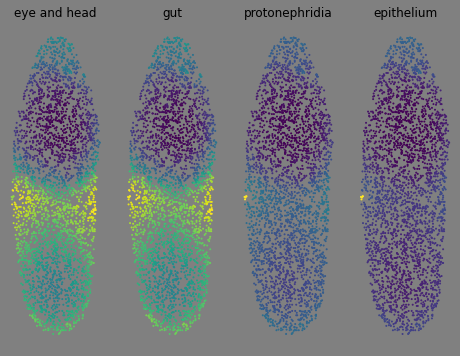

In [28]:
mylen=len(gene_list_to_plot)
plt.figure(figsize=(2*mylen,6),facecolor='grey')

for i in range(len(gene_list_to_plot)):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == gene_list_to_plot[i])[0], :].flatten()        
        plt.scatter(locations[:, 0], locations[:, 1], c=expr_val, s=1)
        plt.title(gene_dict[gene_list_to_plot[i]])
        plt.axis('off')
plt.show()

#### input markers's perdiction

In [29]:
# insitu_genes = ['SMED30004921','SMED30017714','SMED30026600']

In [30]:
ig_marker = [ig in gene_names for ig in insitu_genes]
ig_index = np.nonzero(ig_marker)[0]
ig_list_to_plot = [insitu_genes[i] for i in ig_index]
# ig_list_to_plot

In [31]:
len(ig_list_to_plot)

3

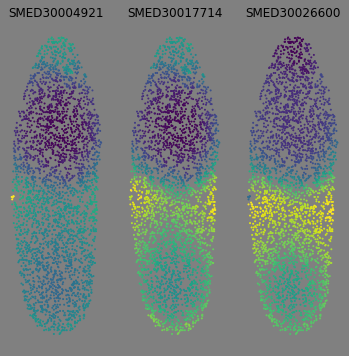

In [32]:
mylen=len(ig_list_to_plot)
plt.figure(figsize=(2*mylen,6),facecolor='grey')

for i in range(mylen):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == ig_list_to_plot[i])[0], :].flatten()        

        plt.scatter(locations[:, 0], locations[:, 1], c=expr_val, s=1)
        plt.title(ig_list_to_plot[i])
        plt.axis('off')
plt.show()

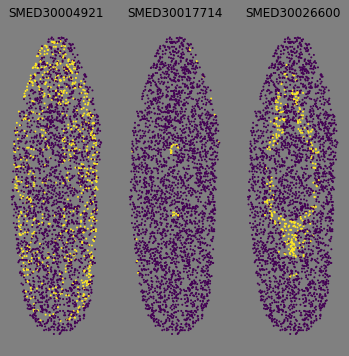

In [33]:
mylen=len(ig_list_to_plot)
plt.figure(figsize=(2*mylen,6),facecolor='grey')
for i in range(mylen):
        plt.subplot(1,mylen,i+1)        
        expr_val = atlas_matrix[:,i]       
        plt.scatter(locations[:, 0], locations[:, 1], c=expr_val, s=1)
        plt.title(ig_list_to_plot[i])
        plt.axis('off')
plt.show()